<h1 style="text-align: center; font-size: 50px;">DreamBooth on Stable Diffusion 2.1</h1>

DreamBooth is a powerful technique for personalizing latent diffusion models, such as Stable Diffusion, allowing the model to be fine-tuned to generate specific images based on a limited set of data.

# Notebook Overview
- Start Execution
- Install and Import Libraries
- Configure Settings
- Verify Assets
- Download model local
- Load the Model
- DreamBooth Training
- Inference Local Model
- Custom Image Quality Metrics
- Model Service

# Start Execution

In [1]:
import logging
import time

# Configure logger
logger: logging.Logger = logging.getLogger("run_workflow_logger")
logger.setLevel(logging.INFO)
logger.propagate = False  # Prevent duplicate logs from parent loggers

# Set formatter
formatter: logging.Formatter = logging.Formatter(
    fmt="%(asctime)s - %(levelname)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)

# Configure and attach stream handler
stream_handler: logging.StreamHandler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

In [2]:
start_time = time.time()  

logger.info("Notebook execution started.")

2025-08-18 19:38:35 - INFO - Notebook execution started.


# Install and Import Libraries

This command installs the "diffusers" library directly from the Hugging Face GitHub repository.The diffusers library is used to work with latent diffusion models, such as Stable Diffusion, and provides tools for image generation, fine-tuning, and other functionalities.


In [3]:
%%time

%pip install -r ../requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.
CPU times: user 17.2 ms, sys: 1.63 ms, total: 18.8 ms
Wall time: 1.15 s


In [4]:
import os
import sys

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import (
    load_configuration,
    load_secrets,
    load_secrets_to_env,
    configure_proxy,
    get_project_root,
    get_config_dir,
    get_output_dir,
    get_default_model_path,
    get_model_cache_dir,
    setup_dreambooth_model
)


# Add the core directory to the path to import utils
core_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if core_path not in sys.path:
    sys.path.append(core_path)

from core.custom_metrics.image_metrics_scorers import entropy_scorer, complexity_scorer, set_custom_image_path
from core.deploy.deploy_image_generation import deploy_model
from core.local_inference.inference import StableDiffusionPipelineOutput, load_config, run_inference
from core.dreambooth_inference.inference_dreambooth import StableDiffusionPipelineOutput, load_config_dreambooth, run_inference_dreambooth


# === Third-Party Imports ===
from huggingface_hub import snapshot_download
import glob
import torch


# === Standard Library Imports ===
import logging
import warnings
from pathlib import Path
from typing import Dict, Any, Optional, Union, List, Tuple


2025-08-18 19:38:37.383225: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 19:38:37.501998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755545917.543410    1196 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755545917.555464    1196 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755545917.657920    1196 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

> ⚠️ **Warning**: If your GPU uses an older architecture (e.g., **pre-Pascal**, such as **Maxwell or earlier**), please uncomment the following line to avoid CUDA timeout issues:
```python
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
```


# Configure Settings

In [5]:
warnings.filterwarnings("ignore")

In [6]:
# === Constants ===
# Model and experiment configuration
project_root = get_project_root()
CONFIG_PATH = "../configs/config.yaml"
SECRETS_PATH = "../configs/secrets.yaml"


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Configuration and Secrets Loading

In this section, we load configuration parameters and API keys from separate YAML files. This separation helps maintain security by keeping sensitive information (API keys) separate from configuration settings.

- **config.yaml**: Contains non-sensitive configuration parameters like model sources and URLs
- **secrets.yaml**: Contains sensitive API keys for services like HuggingFace
- *(Optional for Premium users)* Secrets such as API keys for services like HuggingFace can be stored as environment variables for the project and loaded into the notebook (see the project's README file for steps on how to save secrets in Secrets Manager).

In [8]:
# Load secrets from secrets.yaml file (if it exists) into environment
if Path(SECRETS_PATH).exists():
    load_secrets_to_env(SECRETS_PATH)
else:
    print(f"No secrets file found at {SECRETS_PATH}; relying on preexisting environment")

# Retrieve secrets from environment
try:
    secrets = load_secrets()
except ValueError:
    secrets = {}

# Load configuration and secrets
config = load_configuration(CONFIG_PATH)

print("✅ Configuration loaded successfully")
print("✅ Secrets loaded successfully")

✅ Loaded 1 secrets into environment variables.
✅ Configuration loaded successfully
✅ Secrets loaded successfully


In [9]:
configure_proxy(config)

# Verify Assets

In [10]:
def log_asset_status(asset_path: str, asset_name: str, success_message: str, failure_message: str) -> None:
    """
    Logs the status of a given asset based on its existence.

    Parameters:
        asset_path (str): File or directory path to check.
        asset_name (str): Name of the asset for logging context.
        success_message (str): Message to log if asset exists.
        failure_message (str): Message to log if asset does not exist.
    """
    if Path(asset_path).exists():
        logger.info(f"{asset_name} is properly configured. {success_message}")
    else:
        logger.info(f"{asset_name} is not properly configured. {failure_message}")

def log_secrets_status(secrets: Dict[str, Any], success_message: str, failure_message: str) -> None:
    """
    Logs the status of secrets based on their existence.

    Parameters:
        secrets (Dict[str, Any]): Secrets retrieved to check if they exist.
        success_message (str): Message to log if secrets exists.
        failure_message (str): Message to log if secrets do not exist.
    """
    if secrets:
        logger.info(f"Project secrets are available. {success_message}")
    else:
        logger.info(f"There are no project secrets found. {failure_message}")


log_asset_status(
    asset_path=CONFIG_PATH,
    asset_name="Config",
    success_message="",
    failure_message="Please check if the configs.yaml was propely connfigured in your project on AI Studio."
)

log_secrets_status(
    secrets=secrets,
    success_message="",
    failure_message="Please check if the secrets were propely connfigured in your project's Secrets Manager."
)

2025-08-18 19:38:44 - INFO - Config is properly configured. 
2025-08-18 19:38:44 - INFO - Project secrets are available. 


## Download model local

This code imports the snapshot_download function from the huggingface_hub library to download the latest version of the "stabilityai/stable-diffusion-2-1" model. It sets a local directory for saving the model (local_model_path), and the download is configured to be resumable in case it is interrupted, with an etag timeout set to 60 seconds.

In [11]:
%%time
# Download the snapshot directly to the project's models directory
local_model_path = str(get_project_root() / "models" / "stable-diffusion-2-1")

# Downloading the latest revision of the "stabilityai/stable-diffusion-2-1" model
snapshot_download(
    repo_id="stabilityai/stable-diffusion-2-1", 
    local_dir=local_model_path,
    resume_download=True,
    etag_timeout=60  
)

Fetching 28 files:   0%|          | 0/28 [00:00<?, ?it/s]

CPU times: user 17.3 ms, sys: 45.9 ms, total: 63.2 ms
Wall time: 750 ms


'/home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/models/stable-diffusion-2-1'

## Load the Model
We load the pre-trained Stable Diffusion 2.1 model from Hugging Face and move it to the GPU for efficient execution

Detected 1 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/configs/default_config_one-gpu.yaml
Detected 1 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/configs/default_config_one-gpu.yaml
GPU 0: reserving 13GB ofix VRAM.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Taking `'Attention' object has no attribute 'key'` while using `accelerate.load_checkpoint_and_dispatch` to mean /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/models/stable-diffusion-2-1/vae was saved with deprecated attention block weight names. We will load it with the deprecated attention block names and convert them on the fly to the new attention block format. Please re-save the model after this conversion, so we don't have to do the on the fly renaming in the future. If the model is from a hub checkpoint, please also re-upload it or open a PR on the original repository.


  0%|          | 0/1 [00:00<?, ?it/s]

[1/1]   1.42 s
Saved image to: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/result_0.png

Average: 1.42s | Median: 1.42s | Min: 1.42s | Max: 1.42s


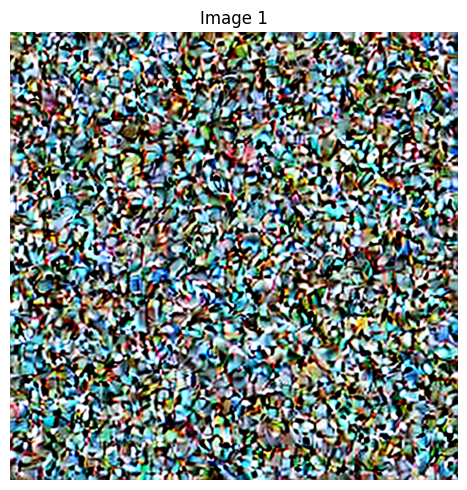

CPU times: user 21.9 s, sys: 6.06 s, total: 28 s
Wall time: 1min 52s


In [12]:
%%time
config = load_config()

run_inference(
    prompt="A beautiful landscape",
    height=768,
    width=768,
    num_images=1,
    num_inference_steps=1,
    output=True  
)

## DreamBooth Training

This Bash script uses PyTorch to detect the number of available GPUs, automatically selects either the multi-GPU or single-GPU configuration file, and then launches the DreamBooth training process on Stable Diffusion via `accelerate launch` with your specified parameters. It also captures the start and end timestamps to calculate the total training duration.

**Tip:** To enable full, verbose logging, add the `--log_level=DEBUG` flag to your command.
> **⏱️ Training time notice**  
> The duration of DreamBooth fine-tuning depends heavily on the model’s hyper-parameters (e.g., number of epochs, learning-rate, batch size, resolution). Reducing these values can speed up training, but expect a possible drop in output-image quality. Tune them according to your time / quality trade-off.

In [13]:
%%bash
NUM_GPUS=$(python3 -c "import torch; print(torch.cuda.device_count())")

PROJECT_ROOT=$(dirname "$(pwd)")

OUTPUT_DIR="${PROJECT_ROOT}/output"
DATA_DIR="${PROJECT_ROOT}/data"


echo "Output dir: $OUTPUT_DIR"
echo "Data dir: $DATA_DIR"


# Ensure directories exist
mkdir -p "$OUTPUT_DIR"
mkdir -p "$DATA_DIR"

if [ "$NUM_GPUS" -ge 2 ]; then
  CONFIG_FILE="../configs/default_config_multi-gpu.yaml"
  echo "Detected $NUM_GPUS GPUs, using $CONFIG_FILE"
else
  CONFIG_FILE="../configs/default_config_one-gpu.yaml"
  echo "Detected $NUM_GPUS GPU, using $CONFIG_FILE"
fi


START=$(date +%s)

accelerate launch --config_file $CONFIG_FILE ../core/train/train_dreambooth_aistudio.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1"  \
  --log_level=ERROR \
  --instance_data_dir="${DATA_DIR}/img" \
  --output_dir="${OUTPUT_DIR}/dreambooth/" \
  --instance_prompt="A modern laptop on a sandy beach with the ocean in the background, sunlight reflecting off the screen" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=2 \
  --logging_dir="/phoenix/tensorboard/tensorlogs" \
  --report_to="tensorboard" \
  --validation_prompt="A photo of an HP laptop on the sand with a sunset over the ocean in the background." \
  --num_validation_images=1 \
  --validation_steps=1

END=$(date +%s)
DIFF=$(( $END - $START ))

Output dir: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output
Data dir: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/data
Detected 1 GPU, using ../configs/default_config_one-gpu.yaml


2025-08-18 19:40:43.759193: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-18 19:40:43.767731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755546043.777117    1403 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755546043.780157    1403 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755546043.787803    1403 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

[2025-08-18 19:48:55,867] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


df: /home/jovyan/.triton/autotune: No such file or directory
Fetching 3 files: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
{'image_encoder'} was not found in config. Values will be initialized to default values.

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]{'timestep_spacing', 'clip_sample_range', 'dynamic_thresholding_ratio', 'sample_max_value', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
Loaded scheduler as DDIMScheduler from `scheduler` subfolder of stabilityai/stable-diffusion-2-1.
Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-1.
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 117.79it/s]
{'timestep_spacing', 'clip_sample_range', 'dynamic_thresholding_ratio', 'sample_max_value', 'rescale_betas_zero_snr', 'thresholding', 'variance_type'} was not found in config. Values will be initialized to default v

## Inference Local Model

This code imports functions from the inference_dreambooth module, loads a configuration, and then runs inference to generate images. It uses a prompt to create three images with a resolution of 768x768 pixels, executing 100 inference steps per image.

Detected 1 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/configs/default_config_one-gpu.yaml
Loading DreamBooth model from: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth
Detected 1 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/configs/default_config_one-gpu.yaml
GPU 0: reserving 13GB of VRAM.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Enabled attention slicing for memory efficiency


  0%|          | 0/100 [00:00<?, ?it/s]

[1/3]  52.54 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_0.png


  0%|          | 0/100 [00:00<?, ?it/s]

[2/3]  52.81 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_1.png


  0%|          | 0/100 [00:00<?, ?it/s]

[3/3]  52.59 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_2.png

Avg 52.65s | Med 52.59s | Min 52.54s | Max 52.81s


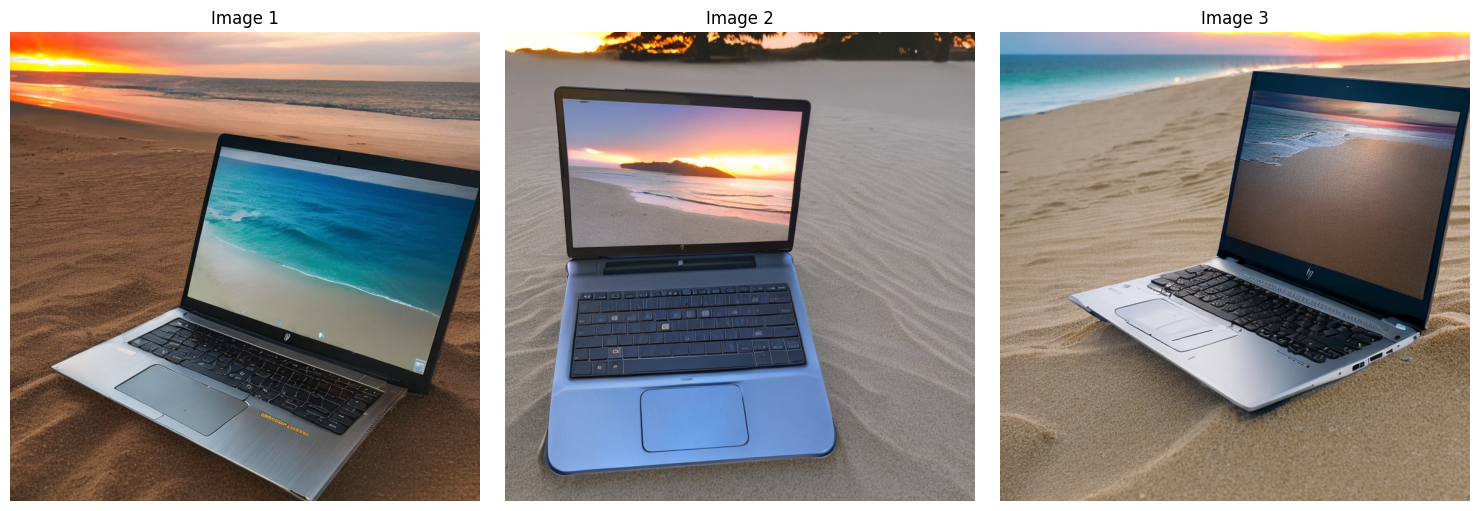

CPU times: user 3min 10s, sys: 11 s, total: 3min 21s
Wall time: 4min 21s


In [14]:
%%time
config = load_config_dreambooth()

# Setup and validate the DreamBooth model
dreambooth_model_path = setup_dreambooth_model()

run_inference_dreambooth(
    prompt="A high-quality photo of an HP laptop placed on the sand at the beach, with a sunset over the ocean in the background.", 
    height=768, 
    width=768, 
    num_images=3, 
    num_inference_steps=100,
    output=True,
    model_path=dreambooth_model_path
)

## Custom Image Quality Metrics
This section demonstrates how to evaluate generated images using custom metrics such as entropy and complexity. These metrics provide insights into the quality and characteristics of the generated images.

In [15]:
def get_latest_generated_image(directory: str = None, prefix: str = "dreambooth_result_", ext: str = ".png") -> str:
    """
    Returns the path of the most recent image that matches the specified pattern.
    Uses the project's output directory by default.
    """
    if directory is None:
        directory = str(get_output_dir())
    
    files = glob.glob(os.path.join(directory, f"{prefix}*{ext}"))
    if not files:
        raise FileNotFoundError(f"No generated images found in {directory}.")
    latest_file = max(files, key=os.path.getmtime)
    return latest_file

Detected 1 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/configs/default_config_one-gpu.yaml
Loading DreamBooth model from: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth
Detected 1 GPU(s); loading /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/configs/default_config_one-gpu.yaml
GPU 0: reserving 13GB of VRAM.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Enabled attention slicing for memory efficiency


  0%|          | 0/100 [00:00<?, ?it/s]

[1/1]  52.30 s - Saved to /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_0.png

Avg 52.30s | Med 52.30s | Min 52.30s | Max 52.30s


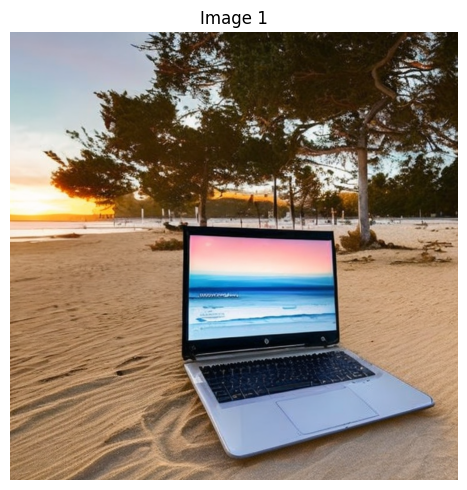

[set_custom_image_path] CUSTOM_IMAGE_PATH: /home/jovyan/AI-Blueprints/generative-ai/image-generation-with-stablediffusion/output/dreambooth_result_0.png
CPU times: user 1min 10s, sys: 6.37 s, total: 1min 16s
Wall time: 2min 3s


In [16]:
%%time
config = load_config_dreambooth()

prompt_text = ("A high-quality photo of an HP laptop placed on the sand at the beach, "
               "with a sunset over the ocean in the background.")

# Setup and validate the DreamBooth model
dreambooth_model_path = setup_dreambooth_model()

# Generate a single image for evaluation
run_inference_dreambooth(
    prompt=prompt_text, 
    height=768, 
    width=768, 
    num_images=1, 
    num_inference_steps=100,
    output=True,
    model_path=dreambooth_model_path
)

# Evaluate the generated image with custom metrics
generated_image_path = get_latest_generated_image()
set_custom_image_path(generated_image_path)

In [17]:
end_time: float = time.time()
elapsed_time: float = end_time - start_time
elapsed_minutes: int = int(elapsed_time // 60)
elapsed_seconds: float = elapsed_time % 60

logger.info(f"⏱️ Total execution time: {elapsed_minutes}m {elapsed_seconds:.2f}s")
logger.info("✅ Notebook execution completed successfully.")

2025-08-18 20:04:12 - INFO - ⏱️ Total execution time: 25m 37.01s
2025-08-18 20:04:12 - INFO - ✅ Notebook execution completed successfully.


Built with ❤️ using Z by HP AI Studio